In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# ----- Dane kalibracyjne (HU -> rho_e/rho_wody) -----
materials = [
    ("Air", -1000, 0.001),
    ("Lung (avg)", -750, 0.26),
    ("Fat", -100, 0.95),
    ("Water", 0, 1.00),
    ("Muscle", 40, 1.05),
    ("Trabecular bone", 300, 1.30),
    ("Cortical bone", 1000, 1.70),
]
labels, HU, rho = zip(*materials)
x_nodes = np.array(HU, dtype=float)
y_nodes = np.array(rho, dtype=float)

# ----- Newton: divided differences -----
def newton_coeffs(x, y):
    x = np.asarray(x, dtype=float)
    c = np.array(y, dtype=float).copy()
    n = len(x)
    for k in range(1, n):
        c[k:n] = (c[k:n] - c[k-1:n-1]) / (x[k:n] - x[0:n-k])
    return c


def newton_eval(z, x, c):
    z = np.asarray(z, dtype=float)
    p = np.full_like(z, c[-1], dtype=float)
    for k in range(len(c) - 2, -1, -1):
        p = p * (z - x[k]) + c[k]
    return p

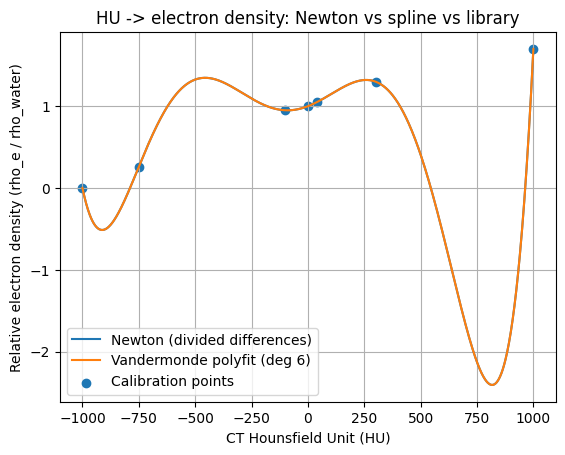

    HU |          Newton |    Polyfit (deg 6)
----------------------------------------------
  -500 |        1.325528 |           1.325528
   150 |        1.223343 |           1.223343
   800 |       -2.385949 |          -2.385949


In [10]:
# ----- Obliczenia -----
# Newton
c_newton = newton_coeffs(x_nodes, y_nodes)


# Library method: Vandermonde (polyfit) -> ten sam wielomian co Newton (inna baza)
deg = len(x_nodes) - 1
coef_poly = np.polyfit(x_nodes, y_nodes, deg)

# Siatka do wykresu
x_plot = np.linspace(x_nodes.min(), x_nodes.max(), 1000)
y_newton = newton_eval(x_plot, x_nodes, c_newton)
y_poly   = np.polyval(coef_poly, x_plot)

# ----- Wykres -----
plt.figure()
plt.plot(x_plot, y_newton, label="Newton (divided differences)")
plt.plot(x_plot, y_poly, label=f"Vandermonde polyfit (deg {deg})")
plt.scatter(x_nodes, y_nodes, label="Calibration points")
plt.xlabel("CT Hounsfield Unit (HU)")
plt.ylabel("Relative electron density (rho_e / rho_water)")
plt.title("HU -> electron density: Newton vs spline vs library")
plt.legend()
plt.grid(True)
plt.show()

targets = np.array([-500.0, 150.0, 800.0])
vals_newton = newton_eval(targets, x_nodes, c_newton)
vals_poly = np.polyval(coef_poly, targets)

print(f"{'HU':>6} | {'Newton':>15} | {'Polyfit (deg '+str(deg)+')':>18}")
print("-"*46)
for hu, vn, vp in zip(targets, vals_newton, vals_poly):
    print(f"{hu:>6.0f} | {vn:>15.6f} | {vp:>18.6f}")